In [7]:
from backtest import do_simulation, perform_closing_strategy, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [4]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

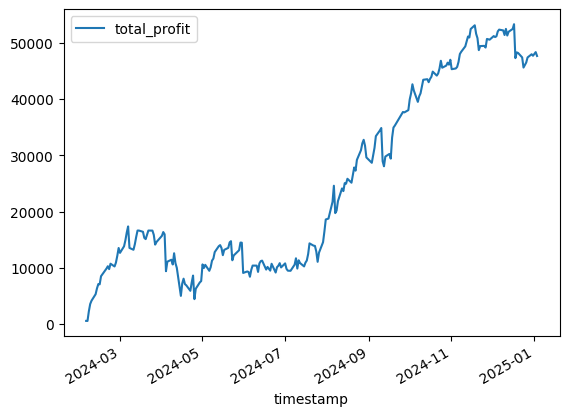

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

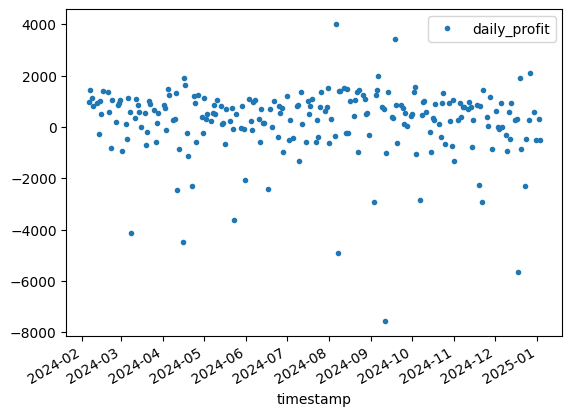

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

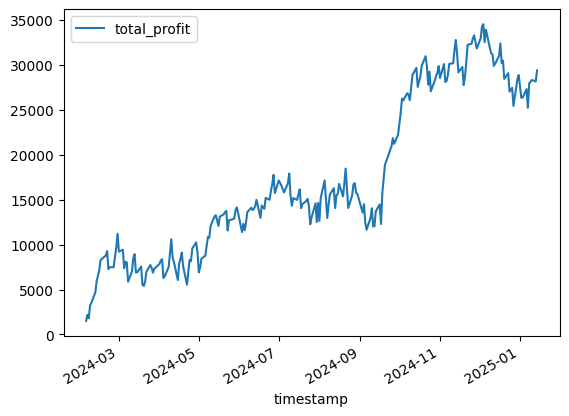

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

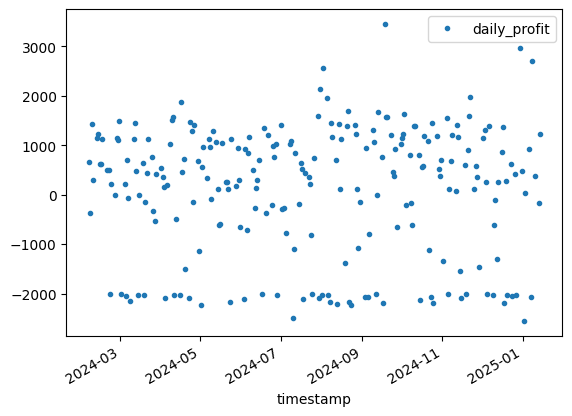

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

Some potential P&L analysis based on daily position movement

In [5]:
EXLUDE_LAST_N = 30

In [6]:
import matplotlib.pyplot as plt

In [8]:
daily_movements = daily_potential_pnl(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
)



100%|██████████| 237/237 [03:05<00:00,  1.28it/s]

Skipped 2 days due to incomplete data. (inserted np.nan for them)


237

In [11]:
daily_movements = [movement for movement in daily_movements if np.isnan(movement).all() == False]
len(daily_movements)

235

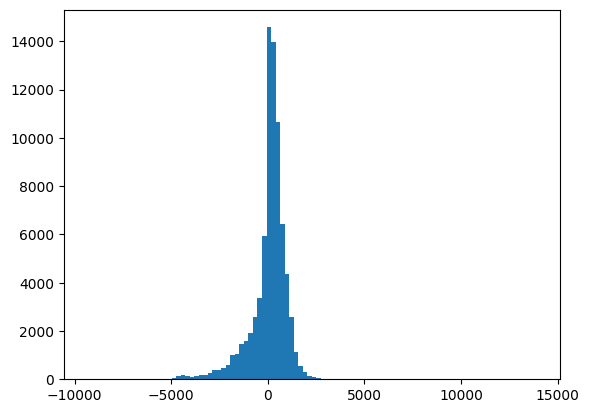

In [12]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

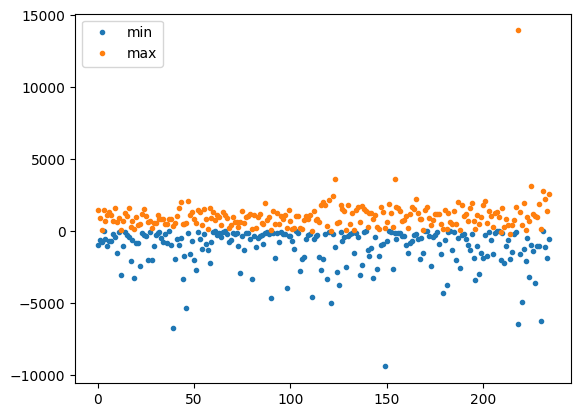

In [13]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [14]:
n_days = daily_min_max_df.shape[0]

In [20]:
profit_categories = [2000, 1750, 1500, 1250, 1000, 800, 750, 500, 400, 300, 250]
loss_categories = [-250, -300, -400, -500, -750, -800, -1000, -1250, -1500, -1750, -2000]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({2000: 0.05531914893617021,
  1750: 0.11063829787234042,
  1500: 0.19148936170212766,
  1250: 0.32340425531914896,
  1000: 0.4765957446808511,
  800: 0.6,
  750: 0.6085106382978723,
  500: 0.7659574468085106,
  400: 0.825531914893617,
  300: 0.8553191489361702,
  250: 0.8723404255319149},
 {-250: 0.7148936170212766,
  -300: 0.6723404255319149,
  -400: 0.6212765957446809,
  -500: 0.5872340425531914,
  -750: 0.46808510638297873,
  -800: 0.451063829787234,
  -1000: 0.39148936170212767,
  -1250: 0.3276595744680851,
  -1500: 0.28936170212765955,
  -1750: 0.24680851063829787,
  -2000: 0.1829787234042553})

In [21]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if closing_strategy_limit_or_stoploss_or_last_n(profit_cat, -loss_cat, EXLUDE_LAST_N)(daily_movement) > 0 else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,2000,1750,1500,1250,1000,800,750,500,400,300,250
-250,0.285106,0.285106,0.285106,0.297872,0.314894,0.365957,0.370213,0.463830,0.519149,0.553191,0.574468
-300,0.327660,0.327660,0.327660,0.340426,0.361702,0.417021,0.421277,0.510638,0.561702,0.604255,0.625532
-400,0.374468,0.374468,0.374468,0.387234,0.404255,0.459574,0.463830,0.561702,0.621277,0.659574,0.680851
-500,0.400000,0.404255,0.404255,0.417021,0.429787,0.493617,0.497872,0.591489,0.646809,0.689362,0.714894
-750,0.493617,0.493617,0.493617,0.502128,0.523404,0.570213,0.574468,0.642553,0.702128,0.740426,0.761702
-800,0.493617,0.493617,0.493617,0.502128,0.523404,0.570213,0.574468,0.642553,0.702128,0.744681,0.765957
-1000,0.544681,0.544681,0.544681,0.553191,0.570213,0.608511,0.612766,0.680851,0.740426,0.774468,0.795745
-1250,0.582979,0.582979,0.582979,0.600000,0.617021,0.655319,0.659574,0.727660,0.774468,0.800000,0.821277
-1500,0.608511,0.608511,0.608511,0.625532,0.642553,0.680851,0.680851,0.744681,0.791489,0.812766,0.829787
-1750,0.625532,0.625532,0.625532,0.638298,0.655319,0.693617,0.693617,0.757447,0.804255,0.825532,0.842553


<Axes: >

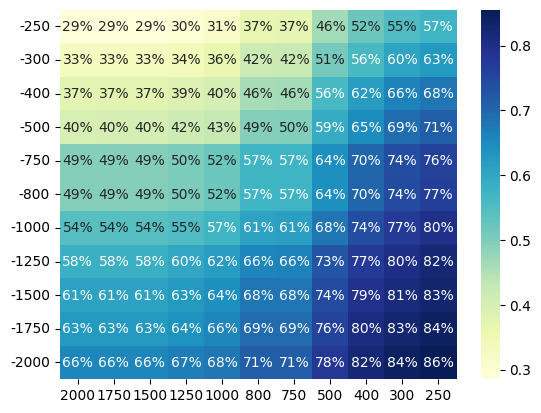

In [24]:
import seaborn as sns

# win rates

sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")